In [1]:
pip install imblearn

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.svm import SVC,SVR
from sklearn import datasets
import scipy.stats as stats
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from collections import Counter
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

seed = 7
np.random.seed(seed)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path='/content/drive/MyDrive/Major Project/New/mangalath-failure modes/Shear-Wall-Failure-Mode-master/Shear_Wall_Database.xlsx'
def dataprocessor(path):
  data1=pd.read_excel(path,sheet_name='Database')
  data=data1.loc[:, 'FailureMode':'Ab/Ag']
  data_mod_lc = data.copy()
  data_mod_lc['Section'] = data_mod_lc['Section'].astype('category')
  #print(cat_bird_lc.dtypes)
  data_mod_lc['Section'] = data_mod_lc['Section'].cat.codes
  data['Section'] = data_mod_lc['Section']
  data = pd.get_dummies(data = data , columns=['Section'] )
  X = data.loc[:, data.columns != 'FailureMode']
  y=data['FailureMode']-1
  return X,y
X,y=dataprocessor(path)
print(X.shape,y.shape)

(393, 11) (393,)


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train.shape,X_test.shape)

(275, 11) (118, 11)


In [5]:
print("Train \n",Counter(y_train))
print("Test \n",Counter(y_test))

Train 
 Counter({0.0: 106, 2.0: 84, 1.0: 66, 3.0: 19})
Test 
 Counter({0.0: 46, 2.0: 38, 1.0: 30, 3.0: 4})


In [6]:
def balance(X_train,y_train):
  print("Before: ",Counter(y_train))
  smote=SMOTE()
  X_train_smote,y_train_smote=smote.fit_resample(X_train.astype('float'),y_train)
  print("After: ",Counter(y_train_smote))
  
  return X_train_smote,y_train_smote

In [7]:
x_new,y_new=balance(X_train,y_train)

Before:  Counter({0.0: 106, 2.0: 84, 1.0: 66, 3.0: 19})
After:  Counter({2.0: 106, 1.0: 106, 3.0: 106, 0.0: 106})


In [8]:
from keras.models import Sequential, Model
from keras.layers import Dense, Input,Dropout
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV

In [9]:
def plot_metrics(history):
    print(history.history.keys())
    plt.figure()
    plt.title('model accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()
    return

In [10]:
def evaluate_model(model,ytrue,ypred):
  cf_matrix=confusion_matrix(ytrue, ypred)
  plt.figure()
  sns.heatmap(cf_matrix, annot=True, 
             cmap='Blues')
  plt.show()
  return

In [13]:
def create_model(optimizer = 'rmsprop',num_of_hl=1,batch_size=16,dropout=0.2,neurons=64,activation='relu'):
    model = Sequential()
    model.add(Dense(neurons, input_shape=(11,), activation=activation))
    for i in range(num_of_hl):
      model.add(Dense(neurons, activation=activation))
      model.add(Dropout(dropout))
    model.add(Dense(4,activation='softmax'))  # 10 is the number of classes in the dataset, you can change it based on your dataset
    model.compile(optimizer = optimizer, loss='categorical_crossentropy',metrics=["accuracy"])
    print(model.summary())
    history=model.fit(X_train, pd.get_dummies(y_train).values,
                      validation_data=(X_test,pd.get_dummies(y_test)),
              batch_size=batch_size,
              epochs=120,
              verbose=0)
    
    plot_metrics(history)
    print(model.evaluate(X_test,pd.get_dummies(y_test)))
    ypred=np.argmax(model.predict(X_test),axis=1)
    # print(ypred)
    evaluate_model(model,y_test,ypred)
    return model

In [12]:
rf_params = {
    
    'optimizer': ['adam','rmsprop','sgd'],
    'activation': ['relu','tanh'],
    'batch_size': [16,32,64,128],
    'dropout':[0.1,0.2,0.3,0.4],
    'neurons':[16,32,64],
    'num_of_hl':[1,2,3]
    
}
n_iter_search=10
clf = KerasClassifier(build_fn=create_model, verbose=0)
Random = RandomizedSearchCV(clf, param_distributions=rf_params,n_iter=n_iter_search,cv=3,scoring='accuracy')
Random.fit(X_train, y_train)
print(Random.best_params_)
print("Accuracy:"+ str(Random.best_score_))

Output hidden; open in https://colab.research.google.com to view.

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_114 (Dense)           (None, 64)                768       
                                                                 
 dense_115 (Dense)           (None, 64)                4160      
                                                                 
 dropout_52 (Dropout)        (None, 64)                0         
                                                                 
 dense_116 (Dense)           (None, 4)                 260       
                                                                 
Total params: 5,188
Trainable params: 5,188
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


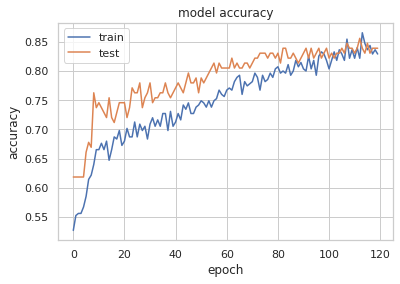

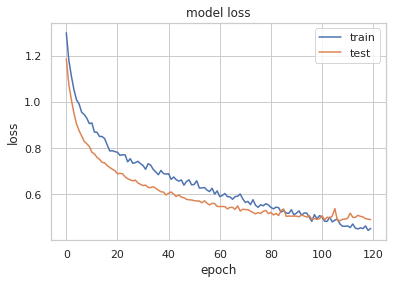

4/4 [==============================] - 0s 4ms/step - loss: 0.4912 - accuracy: 0.8390
[0.4911845326423645, 0.8389830589294434]


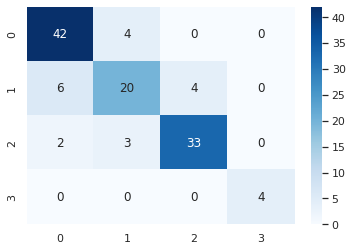

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_117 (Dense)           (None, 64)                768       
                                                                 
 dense_118 (Dense)           (None, 64)                4160      
                                                                 
 dropout_53 (Dropout)        (None, 64)                0         
                                                                 
 dense_119 (Dense)           (None, 4)                 260       
                                                                 
Total params: 5,188
Trainable params: 5,188
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


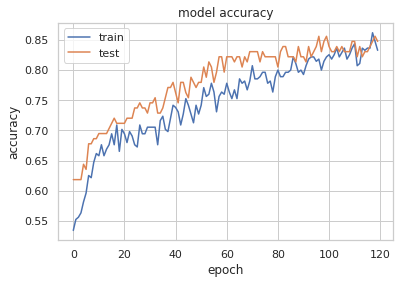

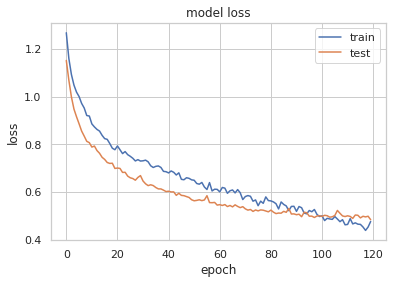

4/4 [==============================] - 0s 4ms/step - loss: 0.4838 - accuracy: 0.8475
[0.48378318548202515, 0.8474576473236084]


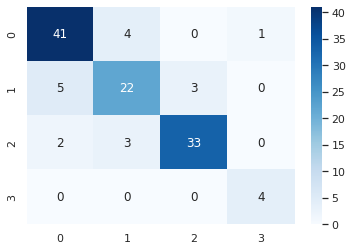

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_120 (Dense)           (None, 64)                768       
                                                                 
 dense_121 (Dense)           (None, 64)                4160      
                                                                 
 dropout_54 (Dropout)        (None, 64)                0         
                                                                 
 dense_122 (Dense)           (None, 4)                 260       
                                                                 
Total params: 5,188
Trainable params: 5,188
Non-trainable params: 0
_________________________________________________________________
None
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


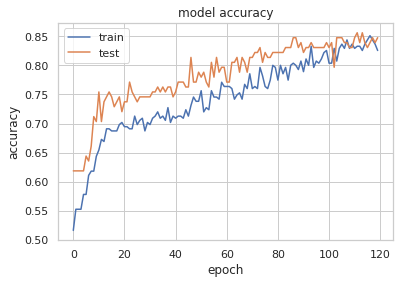

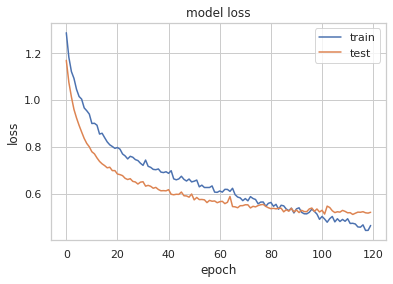

4/4 [==============================] - 0s 3ms/step - loss: 0.5221 - accuracy: 0.8475
[0.5220884680747986, 0.8474576473236084]


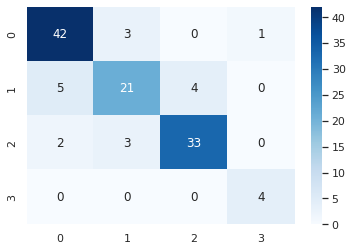

[0.89130435 0.85869565 0.79120879]
Accuracy:0.8470695970695971


In [14]:
clf = KerasClassifier(build_fn=create_model, verbose=0)
scores = cross_val_score(clf, X_train, y_train, cv=3,scoring='accuracy')
print(scores)
print("Accuracy:"+ str(scores.mean()))